# 1: Logistic Fish Population Model (Time-Only ODE)

This notebook analyzes single-species fish population growth using the logistic ordinary differential equation.
It compares analytic and numerical solutions, validates their agreement, and generates core diagnostic plots.

## Model

The governing equation is:

$$
\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right), \quad r>0, K>0
$$

with initial condition $x(0)=x_0>0$.

Analytic solution:

$$
x(t) = \frac{K}{1 + \left(\frac{K-x_0}{x_0}\right)e^{-rt}}
$$

Equilibria are $x^*=0$ and $x^*=K$. For $r>0$, $x^*=0$ is unstable and $x^*=K$ is stable.


## Quick-Look Plot

This is a minimal first view of logistic growth using only the analytic formula.
It is intentionally independent of the full validation workflow below.


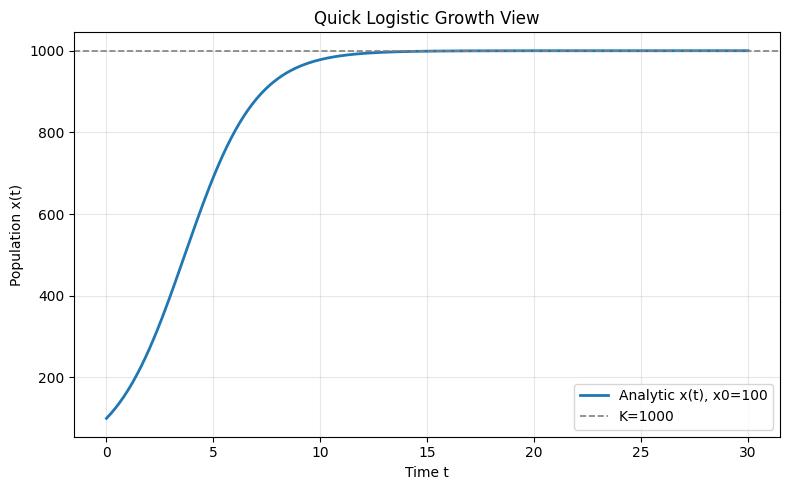

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Quick starter parameters
r_quick: float = 0.6
K_quick: float = 1000.0
x0_quick: float = 100.0
FIG_QUICK: str = "step1_logistic_quick_view.png"

t_quick = np.linspace(0.0, 30.0, 300)
x_quick = K_quick / (1.0 + ((K_quick - x0_quick) / x0_quick) * np.exp(-r_quick * t_quick))

plt.figure(figsize=(8, 5))
plt.plot(t_quick, x_quick, linewidth=2.0, label=f"Analytic x(t), x0={x0_quick:g}")
plt.axhline(K_quick, color="gray", linestyle="--", linewidth=1.2, label=f"K={K_quick:g}")
plt.title("Quick Logistic Growth View")
plt.xlabel("Time t")
plt.ylabel("Population x(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_QUICK, dpi=200)
plt.show()

## Main Execution

Run the code cell below to:
- validate RK45 against the analytic solution across multiple parameter sets,
- check positivity and report warnings if violations occur,
- save the main figures as PNG files and display them.

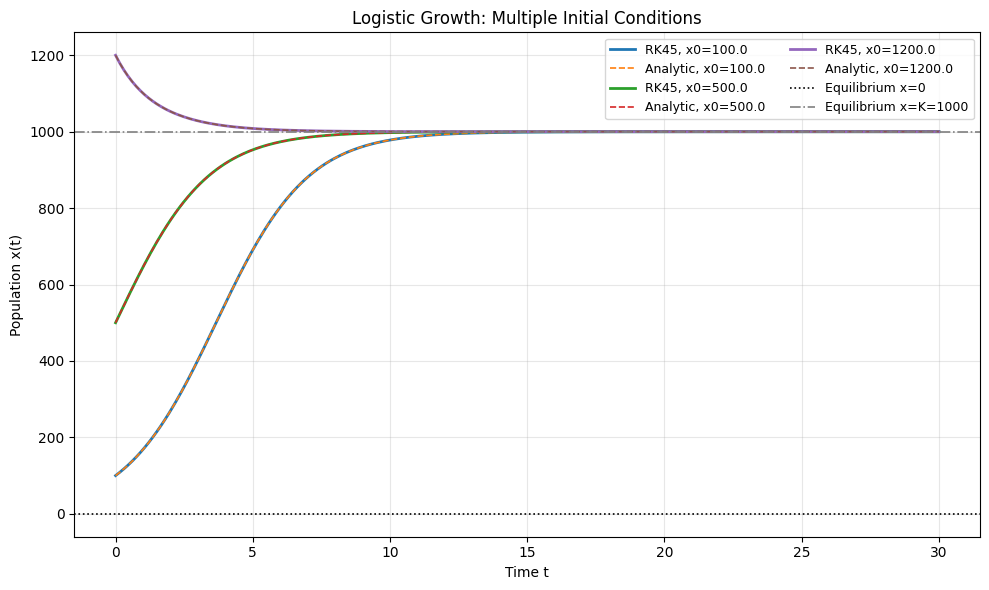

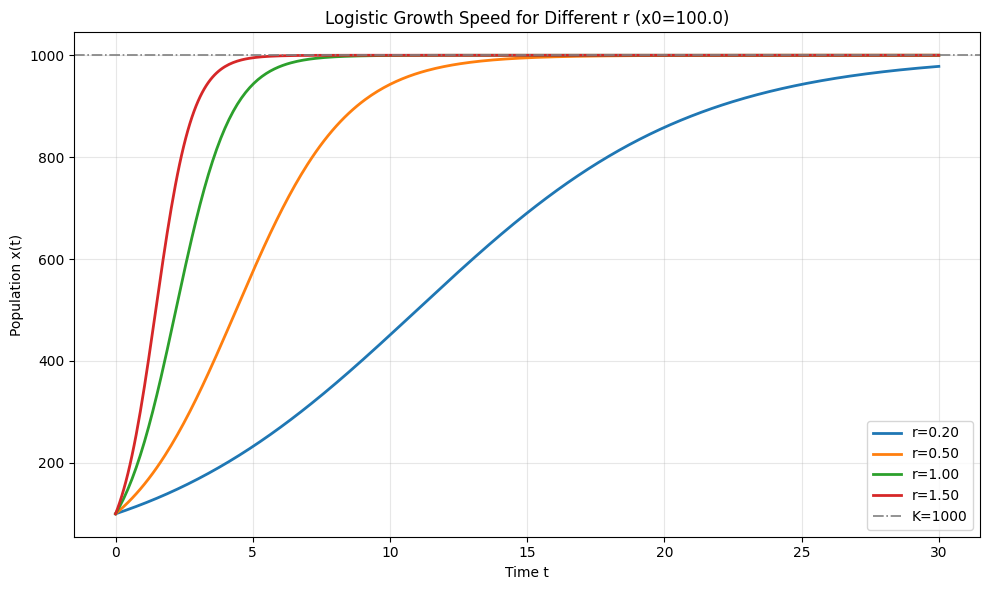

In [2]:
from __future__ import annotations

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp


# -----------------------------
# User-editable model settings
# -----------------------------
T_START: float = 0.0
T_END: float = 30.0
N_POINTS: int = 400
NEGATIVITY_TOL: float = -1e-12

R_MAIN: float = 0.6
K_MAIN: float = 1000.0
X0_LIST: list[float] = [0.1 * K_MAIN, 0.5 * K_MAIN, 1.2 * K_MAIN]

VALIDATION_CASES: list[tuple[float, float, float]] = [
    (0.3, 500.0, 50.0),
    (0.8, 1000.0, 100.0),
    (1.2, 1200.0, 1500.0),
    (0.5, 300.0, 290.0),
]

R_SWEEP: list[float] = [0.2, 0.5, 1.0, 1.5]
X0_SWEEP: float = 0.1 * K_MAIN

FIG_X0_COMPARISON: str = "step1_logistic_x0_comparison.png"
FIG_R_SWEEP: str = "step1_logistic_r_sweep.png"


def logistic_rhs(t: float, x: np.ndarray, r: float, k: float) -> np.ndarray:
    """Return dx/dt for the logistic model."""
    del t  # Autonomous ODE: RHS does not explicitly depend on time.
    return r * x * (1.0 - x / k)


def logistic_analytic(t: np.ndarray, r: float, k: float, x0: float) -> np.ndarray:
    """Closed-form logistic solution for x0 > 0, r > 0, k > 0."""
    if r <= 0.0:
        raise ValueError(f"r must be positive, got {r}")
    if k <= 0.0:
        raise ValueError(f"K must be positive, got {k}")
    if x0 <= 0.0:
        raise ValueError(f"x0 must be positive for analytic formula, got {x0}")

    t_arr = np.asarray(t, dtype=float)
    factor = (k - x0) / x0
    return k / (1.0 + factor * np.exp(-r * t_arr))


def logistic_numeric(t_eval: np.ndarray, r: float, k: float, x0: float) -> np.ndarray:
    """Numerical logistic solution on a provided time grid using RK45."""
    if r <= 0.0:
        raise ValueError(f"r must be positive, got {r}")
    if k <= 0.0:
        raise ValueError(f"K must be positive, got {k}")
    if x0 <= 0.0:
        raise ValueError(f"x0 must be positive, got {x0}")

    t_arr = np.asarray(t_eval, dtype=float)
    if t_arr.ndim != 1 or t_arr.size < 2:
        raise ValueError("t_eval must be a 1D array with at least two points")

    sol = solve_ivp(
        fun=lambda t, y: logistic_rhs(t=t, x=y, r=r, k=k),
        t_span=(float(t_arr[0]), float(t_arr[-1])),
        y0=np.array([x0], dtype=float),
        t_eval=t_arr,
        method="RK45",
        rtol=1e-9,
        atol=1e-12,
    )
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed: {sol.message}")

    return sol.y[0]


def validate_case(
    r: float,
    k: float,
    x0: float,
    t_eval: np.ndarray,
    negativity_tol: float = NEGATIVITY_TOL,
) -> dict[str, float | bool]:
    """Validate one parameter case and return error/positivity metrics."""
    x_numeric = logistic_numeric(t_eval=t_eval, r=r, k=k, x0=x0)
    x_analytic = logistic_analytic(t=t_eval, r=r, k=k, x0=x0)

    max_abs_error = float(np.max(np.abs(x_numeric - x_analytic)))
    min_numeric = float(np.min(x_numeric))
    min_analytic = float(np.min(x_analytic))

    numeric_negative = bool(np.any(x_numeric < negativity_tol))
    analytic_negative = bool(np.any(x_analytic < negativity_tol))

    return {
        "r": r,
        "K": k,
        "x0": x0,
        "max_abs_error": max_abs_error,
        "min_numeric": min_numeric,
        "min_analytic": min_analytic,
        "numeric_negative": numeric_negative,
        "analytic_negative": analytic_negative,
    }


def run_validation_suite(
    cases: list[tuple[float, float, float]],
    t_eval: np.ndarray,
    negativity_tol: float,
) -> list[dict[str, float | bool]]:
    """Run validation over multiple (r, K, x0) sets."""
    results: list[dict[str, float | bool]] = []
    for r, k, x0 in cases:
        metrics = validate_case(r=r, k=k, x0=x0, t_eval=t_eval, negativity_tol=negativity_tol)
        results.append(metrics)

        if bool(metrics["numeric_negative"]):
            print(
                f"WARNING: numerical solution went negative for r={r:.3g}, K={k:.3g}, x0={x0:.3g} "
                f"(min={metrics['min_numeric']:.3e})."
            )
        if bool(metrics["analytic_negative"]):
            print(
                f"WARNING: analytic solution went negative for r={r:.3g}, K={k:.3g}, x0={x0:.3g} "
                f"(min={metrics['min_analytic']:.3e})."
            )

    return results


def plot_initial_condition_comparison(
    t_eval: np.ndarray,
    r: float,
    k: float,
    x0_list: list[float],
    file_name: str,
) -> plt.Figure:
    """Plot x(t) for multiple initial conditions on a single figure."""
    fig, ax = plt.subplots(figsize=(10, 6))

    for x0 in x0_list:
        x_num = logistic_numeric(t_eval=t_eval, r=r, k=k, x0=x0)
        x_an = logistic_analytic(t=t_eval, r=r, k=k, x0=x0)
        ax.plot(t_eval, x_num, linewidth=2.0, label=f"RK45, x0={x0:.1f}")
        ax.plot(t_eval, x_an, "--", linewidth=1.2, label=f"Analytic, x0={x0:.1f}")

    ax.axhline(0.0, color="black", linestyle=":", linewidth=1.2, label="Equilibrium x=0")
    ax.axhline(k, color="gray", linestyle="-.", linewidth=1.2, label=f"Equilibrium x=K={k:g}")

    ax.set_title("Logistic Growth: Multiple Initial Conditions")
    ax.set_xlabel("Time t")
    ax.set_ylabel("Population x(t)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2)

    fig.tight_layout()
    fig.savefig(file_name, dpi=200)
    return fig


def plot_r_sweep(
    t_eval: np.ndarray,
    r_values: list[float],
    k: float,
    x0: float,
    file_name: str,
) -> plt.Figure:
    """Bonus plot: compare growth speed for different intrinsic rates r."""
    fig, ax = plt.subplots(figsize=(10, 6))

    for r in r_values:
        x_num = logistic_numeric(t_eval=t_eval, r=r, k=k, x0=x0)
        ax.plot(t_eval, x_num, linewidth=2.0, label=f"r={r:.2f}")

    ax.axhline(k, color="gray", linestyle="-.", linewidth=1.2, label=f"K={k:g}")
    ax.set_title(f"Logistic Growth Speed for Different r (x0={x0:.1f})")
    ax.set_xlabel("Time t")
    ax.set_ylabel("Population x(t)")
    ax.grid(True, alpha=0.3)
    ax.legend()

    fig.tight_layout()
    fig.savefig(file_name, dpi=200)
    return fig


# -----------------------------
# Main execution
# -----------------------------
t_eval = np.linspace(T_START, T_END, N_POINTS)

_ = run_validation_suite(cases=VALIDATION_CASES, t_eval=t_eval, negativity_tol=NEGATIVITY_TOL)

_ = plot_initial_condition_comparison(
    t_eval=t_eval,
    r=R_MAIN,
    k=K_MAIN,
    x0_list=X0_LIST,
    file_name=FIG_X0_COMPARISON,
)

_ = plot_r_sweep(
    t_eval=t_eval,
    r_values=R_SWEEP,
    k=K_MAIN,
    x0=X0_SWEEP,
    file_name=FIG_R_SWEEP,
)

plt.show()

## 2: Logistic Growth with Fishing (Harvesting)

We now include constant proportional harvesting in the time-only logistic model:

$$
\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right) - h x
$$

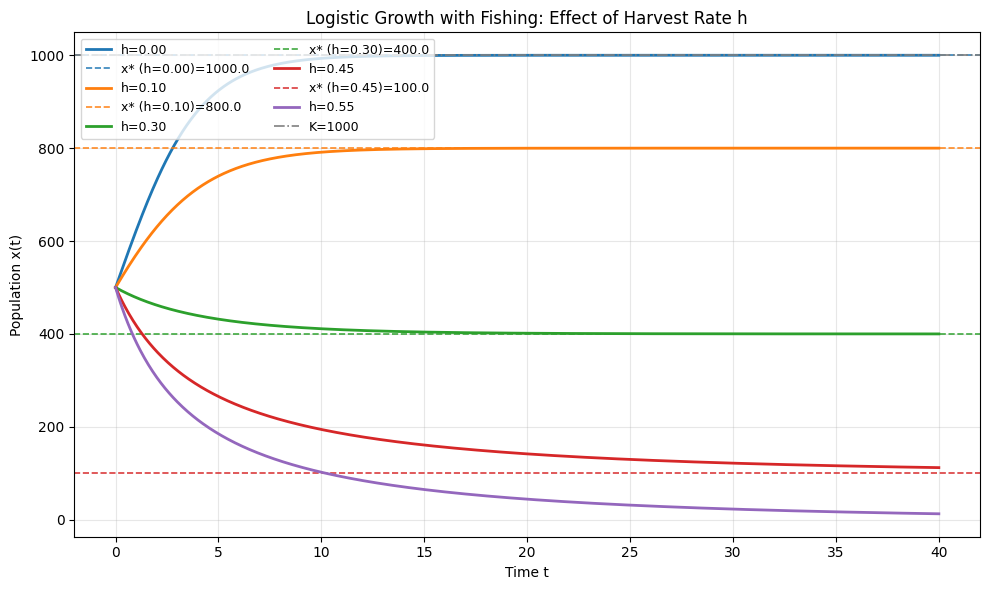

In [3]:
# Figure C: Logistic growth with fishing (constant harvesting rate h)
def harvested_rhs(t: float, x: np.ndarray, r: float, K: float, h: float) -> np.ndarray:
    """Right-hand side for harvested logistic growth."""
    del t  # Autonomous ODE.
    return r * x * (1.0 - x / K) - h * x


def harvested_analytic(
    t: np.ndarray,
    x0: float,
    r: float,
    K: float,
    h: float,
):
    """Analytic harvested logistic solution for h < r; otherwise None."""
    if h >= r:
        return None

    t_arr = np.asarray(t, dtype=float)
    a = r - h
    K_eff = K * (1.0 - h / r)
    return K_eff / (1.0 + ((K_eff - x0) / x0) * np.exp(-a * t_arr))


# Required parameters
K_h: float = 1000.0
r_h: float = 0.50
x0_h: float = 500.0
t_h = np.linspace(0.0, 40.0, 801)  # dense time grid
h_values: list[float] = [0.00, 0.10, 0.30, 0.45, 0.55]

fig_c, ax_c = plt.subplots(figsize=(10, 6))

for h in h_values:
    sol = solve_ivp(
        fun=lambda t, y, h_val=h: harvested_rhs(t=t, x=y, r=r_h, K=K_h, h=h_val),
        t_span=(float(t_h[0]), float(t_h[-1])),
        y0=np.array([x0_h], dtype=float),
        t_eval=t_h,
        method="RK45",
        rtol=1e-9,
        atol=1e-12,
    )
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed for h={h:.2f}: {sol.message}")

    x_num = sol.y[0]
    line, = ax_c.plot(t_h, x_num, linewidth=2.0, label=f"h={h:.2f}")

    if h < r_h:
        x_star = K_h * (1.0 - h / r_h)
        ax_c.axhline(
            x_star,
            color=line.get_color(),
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
            label=f"x* (h={h:.2f})={x_star:.1f}",
        )

ax_c.axhline(K_h, color="gray", linestyle="-.", linewidth=1.2, label=f"K={K_h:g}")
ax_c.set_title("Logistic Growth with Fishing: Effect of Harvest Rate h")
ax_c.set_xlabel("Time t")
ax_c.set_ylabel("Population x(t)")
ax_c.grid(True, alpha=0.3)
ax_c.legend(fontsize=9, ncol=2)
fig_c.tight_layout()
plt.show()

# 3A — Pure Diffusion Sanity Check (Migration Only)

**Purpose:** validate the spatial finite-difference discretisation and Neumann (no-flux) boundary conditions *before* adding logistic growth or fishing.

We solve the pure diffusion PDE on the offshore-distance domain $s \in [0, L]$:

$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial s^2}
$$

with no-flux boundaries:

$$
\frac{\partial u}{\partial s}(0,t) = 0, \qquad \frac{\partial u}{\partial s}(L,t) = 0
$$

**Expected behaviour:**
- The initial Gaussian bump (centred at $s = 150$) spreads and flattens over time.
- Total mass $M(t) = \int_0^L u(s,t)\,ds$ is conserved (no-flux + no reaction).

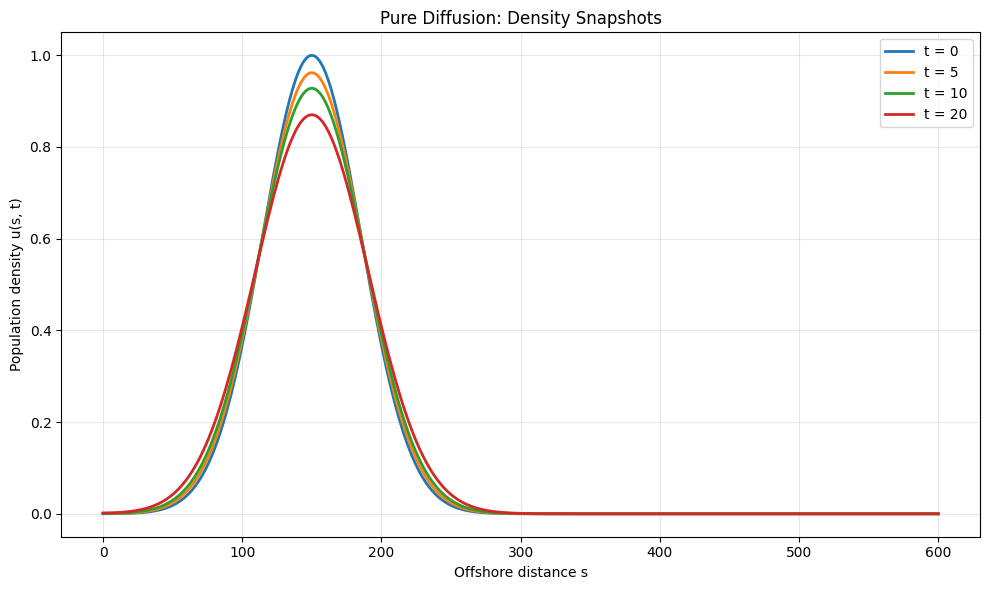

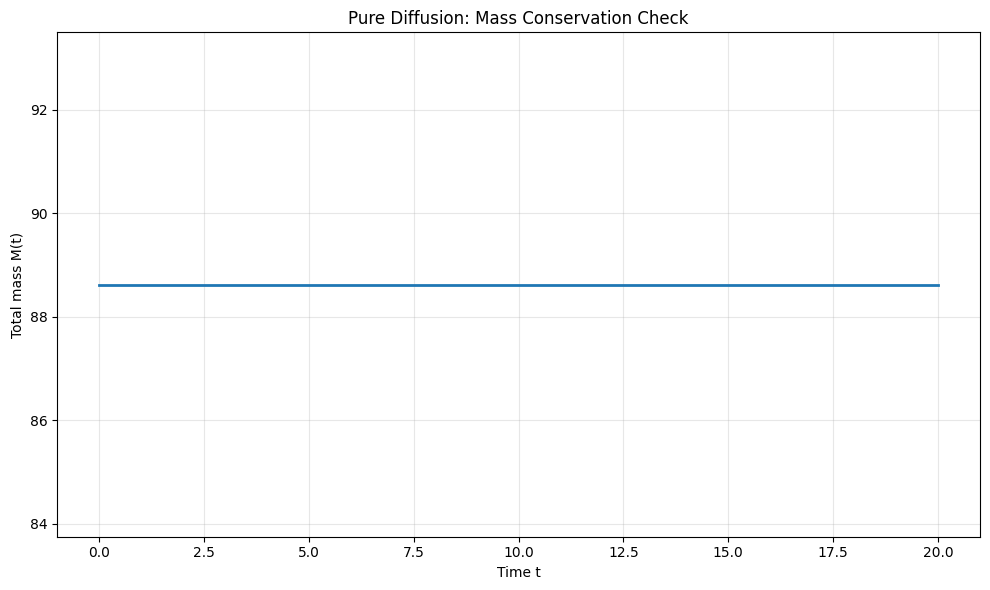

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# ── Parameters ───────────────────────────────────────────────────────
L: float = 600.0          # domain length (offshore distance)
N: int = 301              # number of grid points
ds: float = L / (N - 1)   # spatial step

D: float = 10.0           # diffusion coefficient
T_end: float = 20.0       # simulation end time

# Stability-guided time step: dt <= ds^2 / (2D)
dt_max = ds**2 / (2.0 * D)
dt = 0.45 * dt_max
nt = int(np.ceil(T_end / dt))
dt = T_end / nt            # adjust so simulation lands exactly on T_end

s = np.linspace(0.0, L, N)


# ── Helper: Laplacian with Neumann BCs (ghost-point equivalence) ────
def laplacian_neumann(u: np.ndarray, ds: float) -> np.ndarray:
    """Second spatial derivative with no-flux (Neumann) boundaries.

    Ghost-point equivalence gives:
        left  boundary: d²u/ds² ≈ 2*(u[1]  - u[0] ) / ds²
        right boundary: d²u/ds² ≈ 2*(u[-2] - u[-1]) / ds²
    """
    d2u = np.empty_like(u)
    inv_ds2 = 1.0 / ds**2
    # interior points
    d2u[1:-1] = (u[2:] - 2.0 * u[1:-1] + u[:-2]) * inv_ds2
    # boundaries (Neumann via ghost point)
    d2u[0] = 2.0 * (u[1] - u[0]) * inv_ds2
    d2u[-1] = 2.0 * (u[-2] - u[-1]) * inv_ds2
    return d2u


# ── Initial condition: Gaussian bump centred offshore ────────────────
s_peak: float = 150.0      # peak density at 150 miles offshore
u = np.exp(-((s - s_peak) / 50.0)**2)

# ── Time integration (explicit Euler) ────────────────────────────────
snapshot_times = {0.0, 5.0, 10.0, 20.0}
snapshots: dict[float, np.ndarray] = {0.0: u.copy()}

mass_history = np.empty(nt + 1)
time_history = np.empty(nt + 1)
mass_history[0] = np.trapezoid(u, s)
time_history[0] = 0.0

t = 0.0
for n in range(1, nt + 1):
    u = u + dt * D * laplacian_neumann(u, ds)
    t = n * dt
    mass_history[n] = np.trapezoid(u, s)
    time_history[n] = t
    # capture snapshots (allow small floating-point tolerance)
    for ts in list(snapshot_times):
        if abs(t - ts) < 0.5 * dt:
            snapshots[ts] = u.copy()
            snapshot_times.discard(ts)

# ── Density snapshots ───────────────────────────────────────────────
fig_a, ax_a = plt.subplots(figsize=(10, 6))
for t_snap in sorted(snapshots):
    ax_a.plot(s, snapshots[t_snap], linewidth=2.0, label=f"t = {t_snap:g}")
ax_a.set_title("Pure Diffusion: Density Snapshots")
ax_a.set_xlabel("Offshore distance s")
ax_a.set_ylabel("Population density u(s, t)")
ax_a.grid(True, alpha=0.3)
ax_a.legend()
fig_a.tight_layout()
plt.show()

# ── Mass conservation check ─────────────────────────────────────────
fig_b, ax_b = plt.subplots(figsize=(10, 6))
ax_b.plot(time_history, mass_history, linewidth=2.0)
ax_b.set_title("Pure Diffusion: Mass Conservation Check")
ax_b.set_xlabel("Time t")
ax_b.set_ylabel("Total mass M(t)")
ax_b.grid(True, alpha=0.3)
fig_b.tight_layout()
plt.show()

# 3B — Reaction–Diffusion: Logistic Growth + Migration (No Fishing)

We now combine logistic growth with spatial diffusion:

$$
\frac{\partial u}{\partial t} = r\,u\!\left(1 - \frac{u}{K}\right) + D\,\frac{\partial^2 u}{\partial s^2}
$$

on $s \in [0, L]$ with no-flux (Neumann) boundary conditions, using the same grid and `laplacian_neumann` helper from 3A.

**Two sub-experiments:**
- **(A) Non-uniform IC** — Gaussian bump centred at $s = 150$: observe growth filling the tails toward $K$ while diffusion smooths the profile.
- **(B) Uniform IC validation** — spatially constant $u_0 = 0.2K$: the PDE should reduce to the logistic ODE (no spatial gradients → no diffusion). We overlay the analytic logistic solution to confirm.

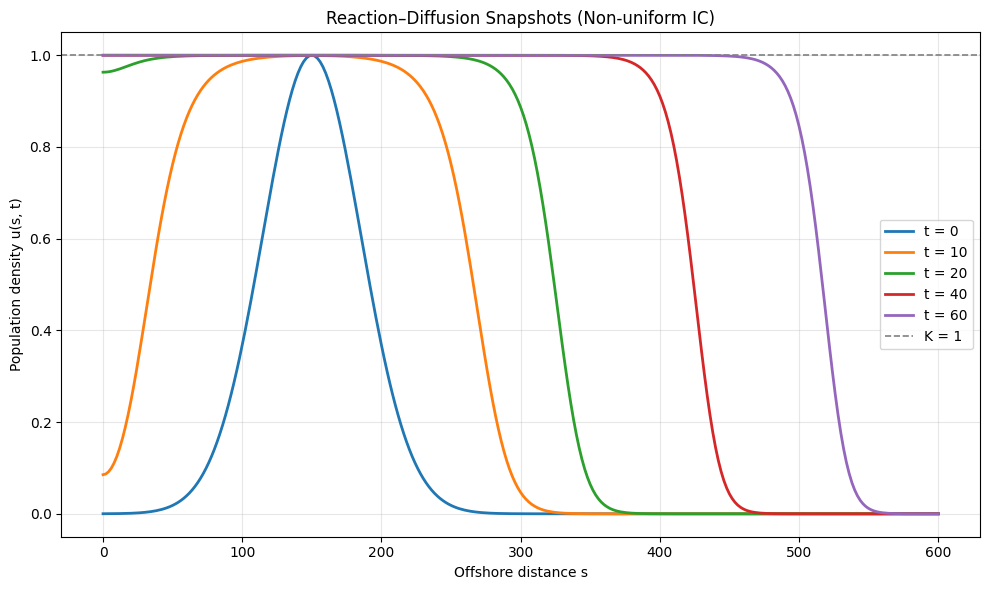

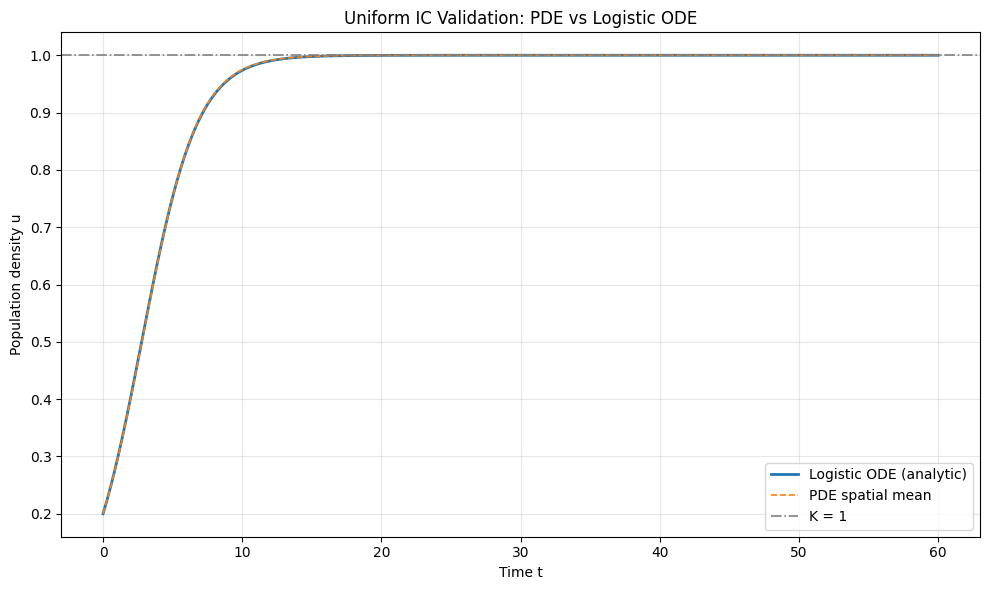

In [5]:
import numpy as np
from matplotlib import pyplot as plt

# ── Parameters (same grid as 3A) ────────────────────────────────────
L_rd: float = 600.0
N_rd: int = 301
ds_rd: float = L_rd / (N_rd - 1)

D_rd: float = 10.0        # diffusion coefficient (same as 3A)
K_rd: float = 1.0         # carrying capacity (O(1), consistent with Gaussian IC)
r_rd: float = 0.5         # intrinsic growth rate
T_end_rd: float = 60.0    # long enough for convergence to K

# Explicit Euler stability: dt <= ds^2 / (2D)
dt_rd = 0.45 * ds_rd**2 / (2.0 * D_rd)
nt_rd = int(np.ceil(T_end_rd / dt_rd))
dt_rd = T_end_rd / nt_rd  # adjust so we land exactly on T_end

s_rd = np.linspace(0.0, L_rd, N_rd)

# =====================================================================
# Part A — Non-uniform IC (Gaussian bump centred offshore)
# =====================================================================
s_peak_rd: float = 150.0   # peak density at 150 miles offshore
u_a = np.exp(-((s_rd - s_peak_rd) / 50.0)**2)

snapshot_times_a = {0.0, 10.0, 20.0, 40.0, 60.0}
snapshots_a: dict[float, np.ndarray] = {0.0: u_a.copy()}

t_a = 0.0
for n in range(1, nt_rd + 1):
    lap = laplacian_neumann(u_a, ds_rd)
    u_a = u_a + dt_rd * (r_rd * u_a * (1.0 - u_a / K_rd) + D_rd * lap)
    t_a = n * dt_rd
    for ts in list(snapshot_times_a):
        if abs(t_a - ts) < 0.5 * dt_rd:
            snapshots_a[ts] = u_a.copy()
            snapshot_times_a.discard(ts)

# ── Plot: Non-uniform IC snapshots ──────────────────────────────────
fig_a, ax_a = plt.subplots(figsize=(10, 6))
for t_snap in sorted(snapshots_a):
    ax_a.plot(s_rd, snapshots_a[t_snap], linewidth=2.0, label=f"t = {t_snap:g}")
ax_a.axhline(K_rd, color="gray", linestyle="--", linewidth=1.2, label=f"K = {K_rd:g}")
ax_a.set_title("Reaction–Diffusion Snapshots (Non-uniform IC)")
ax_a.set_xlabel("Offshore distance s")
ax_a.set_ylabel("Population density u(s, t)")
ax_a.grid(True, alpha=0.3)
ax_a.legend()
fig_a.tight_layout()
plt.show()

# =====================================================================
# Part B — Uniform IC validation
# =====================================================================
u0_uniform = 0.2 * K_rd
u_b = u0_uniform * np.ones(N_rd)

# Track spatial mean and max deviation at each step
mean_history = np.empty(nt_rd + 1)
max_dev_history = np.empty(nt_rd + 1)
time_history_b = np.empty(nt_rd + 1)

mean_history[0] = u_b.mean()
max_dev_history[0] = u_b.max() - u_b.min()
time_history_b[0] = 0.0

for n in range(1, nt_rd + 1):
    lap = laplacian_neumann(u_b, ds_rd)
    u_b = u_b + dt_rd * (r_rd * u_b * (1.0 - u_b / K_rd) + D_rd * lap)
    time_history_b[n] = n * dt_rd
    mean_history[n] = u_b.mean()
    max_dev_history[n] = u_b.max() - u_b.min()

# Analytic logistic ODE solution (reuse from section 1)
u_analytic = logistic_analytic(time_history_b, r=r_rd, k=K_rd, x0=u0_uniform)

# ── Plot: Uniform IC validation ─────────────────────────────────────
fig_b, ax_b = plt.subplots(figsize=(10, 6))
ax_b.plot(time_history_b, u_analytic, linewidth=2.0, label="Logistic ODE (analytic)")
ax_b.plot(time_history_b, mean_history, "--", linewidth=1.2, label="PDE spatial mean")
ax_b.axhline(K_rd, color="gray", linestyle="-.", linewidth=1.2, label=f"K = {K_rd:g}")
ax_b.set_title("Uniform IC Validation: PDE vs Logistic ODE")
ax_b.set_xlabel("Time t")
ax_b.set_ylabel("Population density u")
ax_b.grid(True, alpha=0.3)
ax_b.legend()
fig_b.tight_layout()
plt.show()

# 3C — Reaction–Diffusion with Fishing Policy (200-mile Boundary)

We now add spatially varying harvesting to the reaction–diffusion PDE:

$$
\frac{\partial u}{\partial t} = r\,u\!\left(1 - \frac{u}{K}\right) - h(s,t)\,u + D\,\frac{\partial^2 u}{\partial s^2}
$$

The fishing rate $h(s,t)$ is **piecewise constant** across a policy boundary at $s = s_{\mathrm{boundary}}$:

$$
h(s,t) = \begin{cases} h_{\mathrm{in}} & s \le s_{\mathrm{boundary}} \\[4pt] h_{\mathrm{out}} & s > s_{\mathrm{boundary}} \end{cases}
$$

with an optional time-limited **pulse** that temporarily raises $h_{\mathrm{out}}$.

**Four policy scenarios:**

| Scenario | $h_{\mathrm{in}}$ | $h_{\mathrm{out}}$ | Pulse | Description |
|----------|-------------------|---------------------|-------|-------------|
| A | 0.0 | 0.0 | — | No fishing (baseline, should match 3B) |
| B | 0.2 | 0.2 | — | Uniform fishing everywhere |
| C | 0.0 | 0.2 | — | 200-mile ban: protected inshore, fished offshore |
| D | 0.0 | 0.2 | $h_{\mathrm{out}}=0.8$ for $t \in [20,25]$ | Same as C + intense offshore pulse |

**Expected behaviour:**
- **A:** identical to 3B — growth fills toward $K$ everywhere.
- **B:** fishing depresses the equilibrium below $K$ uniformly.
- **C:** inshore zone reaches $K$; offshore zone is depressed; diffusion creates a spillover gradient near $s_{\mathrm{boundary}}$.
- **D:** transient dip in offshore biomass and catch during the pulse, followed by partial recovery.

In [6]:
import numpy as np
from matplotlib import pyplot as plt


def simulate_rd_fishing(
    L: float,
    N: int,
    D: float,
    r: float,
    K: float,
    T_end: float,
    s_boundary: float = 200.0,
    h_in: float = 0.0,
    h_out: float = 0.2,
    pulse: dict | None = None,
    u0_type: str = "gaussian",
    u0_uniform: float | None = None,
    gaussian_center: float = 150.0,
    gaussian_scale: float = 50.0,
    snapshot_times: list[float] | None = None,
    dt_safety: float = 0.45,
    store_full: bool = False,
    full_n_frames: int = 300,
) -> dict:
    """Simulate reaction-diffusion PDE with spatially varying fishing.

    Parameters
    ----------
    L, N          : domain length and grid points
    D, r, K       : diffusion, growth rate, carrying capacity
    T_end         : simulation end time
    s_boundary    : policy boundary (inshore/offshore split)
    h_in, h_out   : fishing rates for s <= s_boundary and s > s_boundary
    pulse         : optional dict with keys "t_start", "t_end", "h_out_pulse"
    u0_type       : "gaussian" or "uniform"
    u0_uniform    : initial value if u0_type == "uniform" (default 0.2*K)
    gaussian_center: centre of Gaussian IC (offshore distance of peak density)
    gaussian_scale: width parameter for Gaussian IC
    snapshot_times: list of times at which to store spatial snapshots
    dt_safety     : safety factor for diffusion stability

    Returns
    -------
    dict with keys: s, time, snapshots, B_in, B_out, B_tot, Catch,
                    CumCatch, ds, dt, nt, min_u, s_boundary
                    (+ u_full, t_full when store_full=True)
    """
    if snapshot_times is None:
        snapshot_times = [0.0, 10.0, 20.0, 40.0, 60.0]

    ds = L / (N - 1)
    s = np.linspace(0.0, L, N)

    # -- dt: diffusion stability AND reaction/fishing safety -------------
    dt = dt_safety * ds**2 / (2.0 * D)
    h_pulse_val = pulse["h_out_pulse"] if pulse else 0.0
    max_rate = max(r, h_in, h_out, h_pulse_val, 1e-12)
    dt = min(dt, 0.2 / max_rate)
    nt = int(np.ceil(T_end / dt))
    dt = T_end / nt

    # -- boundary index --------------------------------------------------
    i_bnd = int(np.searchsorted(s, s_boundary, side="right")) - 1

    # -- initial condition ------------------------------------------------
    if u0_type == "gaussian":
        u = np.exp(-((s - gaussian_center) / gaussian_scale) ** 2)
    else:
        u = (u0_uniform if u0_uniform is not None else 0.2 * K) * np.ones(N)

    # -- base fishing-rate array -----------------------------------------
    h_base = np.empty(N)
    h_base[: i_bnd + 1] = h_in
    h_base[i_bnd + 1 :] = h_out

    # -- full space-time storage (subsampled) ----------------------------
    if store_full:
        save_every = max(1, nt // full_n_frames)
        n_saved = nt // save_every + 1
        u_full = np.empty((n_saved, N))
        t_full = np.empty(n_saved)
        u_full[0] = u.copy()
        t_full[0] = 0.0
        full_idx = 1

    # -- storage ---------------------------------------------------------
    snap_set = set(snapshot_times)
    snapshots: dict[float, np.ndarray] = {}
    if 0.0 in snap_set:
        snapshots[0.0] = u.copy()

    time_arr = np.empty(nt + 1)
    B_in = np.empty(nt + 1)
    B_out = np.empty(nt + 1)
    B_tot = np.empty(nt + 1)
    Catch = np.empty(nt + 1)
    CumCatch = np.empty(nt + 1)

    time_arr[0] = 0.0
    B_in[0] = np.trapezoid(u[: i_bnd + 1], s[: i_bnd + 1])
    B_out[0] = np.trapezoid(u[i_bnd:], s[i_bnd:])
    B_tot[0] = np.trapezoid(u, s)
    Catch[0] = np.trapezoid(h_base * u, s)
    CumCatch[0] = 0.0

    min_u = float(u.min())

    # -- time stepping ---------------------------------------------------
    for n in range(1, nt + 1):
        t_now = n * dt

        # fishing rate at this time (apply pulse if active)
        if pulse and pulse["t_start"] <= t_now <= pulse["t_end"]:
            h_arr = h_base.copy()
            h_arr[i_bnd + 1 :] = pulse["h_out_pulse"]
        else:
            h_arr = h_base

        lap = laplacian_neumann(u, ds)
        u = u + dt * (r * u * (1.0 - u / K) - h_arr * u + D * lap)

        # diagnostics
        cur_min = float(u.min())
        if cur_min < min_u:
            min_u = cur_min

        time_arr[n] = t_now
        B_in[n] = np.trapezoid(u[: i_bnd + 1], s[: i_bnd + 1])
        B_out[n] = np.trapezoid(u[i_bnd:], s[i_bnd:])
        B_tot[n] = np.trapezoid(u, s)
        Catch[n] = np.trapezoid(h_arr * u, s)
        CumCatch[n] = CumCatch[n - 1] + dt * Catch[n - 1]

        # store full space-time data (subsampled)
        if store_full and n % save_every == 0 and full_idx < n_saved:
            u_full[full_idx] = u.copy()
            t_full[full_idx] = t_now
            full_idx += 1

        # capture snapshots
        for ts in list(snap_set):
            if abs(t_now - ts) < 0.5 * dt:
                snapshots[ts] = u.copy()
                snap_set.discard(ts)

    if min_u < -1e-10:
        print(f"  WARNING: min(u) = {min_u:.3e} (negative!)")

    result = {
        "s": s,
        "time": time_arr,
        "snapshots": snapshots,
        "B_in": B_in,
        "B_out": B_out,
        "B_tot": B_tot,
        "Catch": Catch,
        "CumCatch": CumCatch,
        "ds": ds,
        "dt": dt,
        "nt": nt,
        "min_u": min_u,
        "s_boundary": s_boundary,
    }

    if store_full:
        result["u_full"] = u_full[:full_idx]
        result["t_full"] = t_full[:full_idx]

    return result

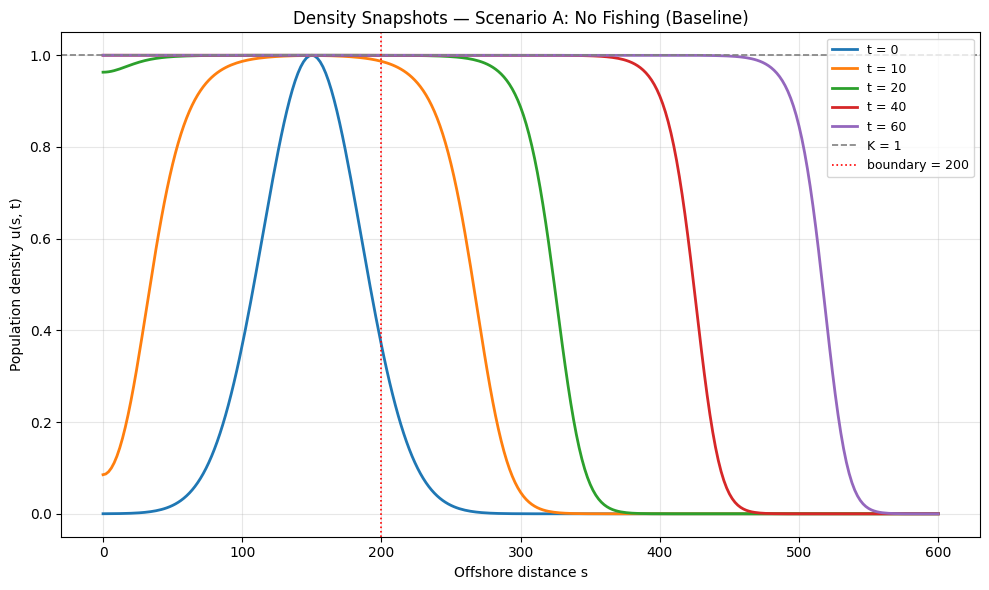

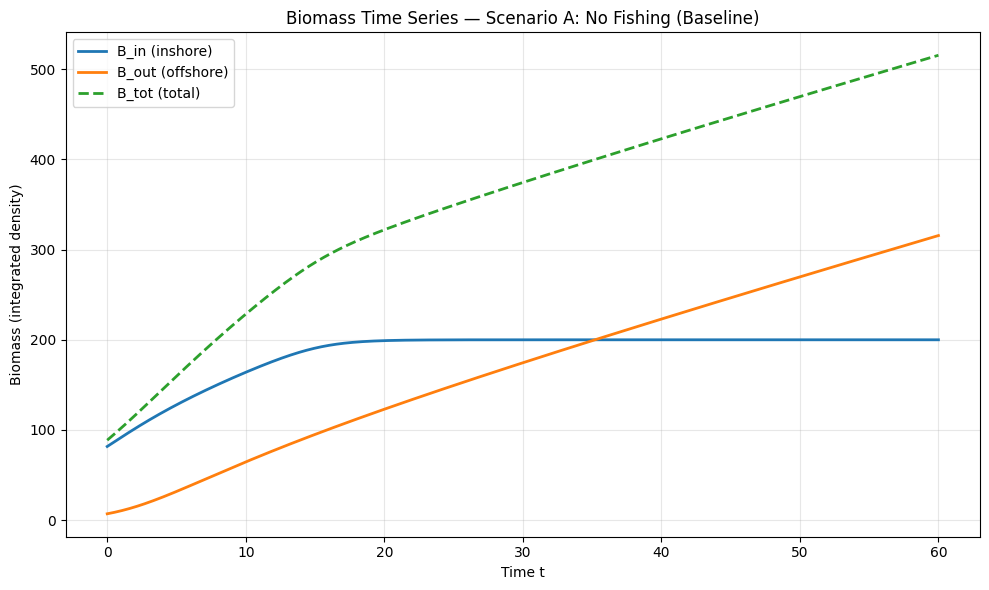

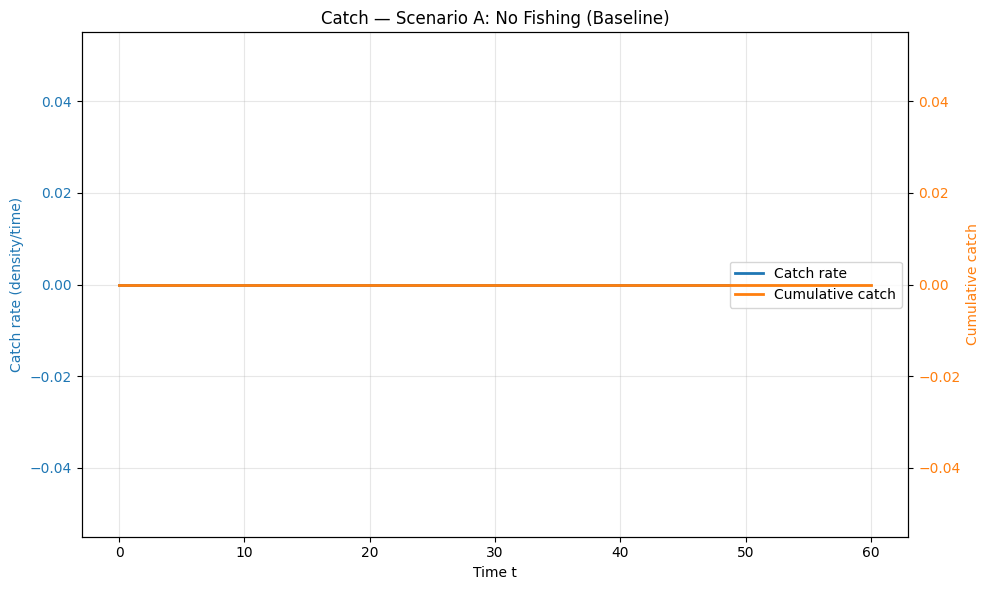

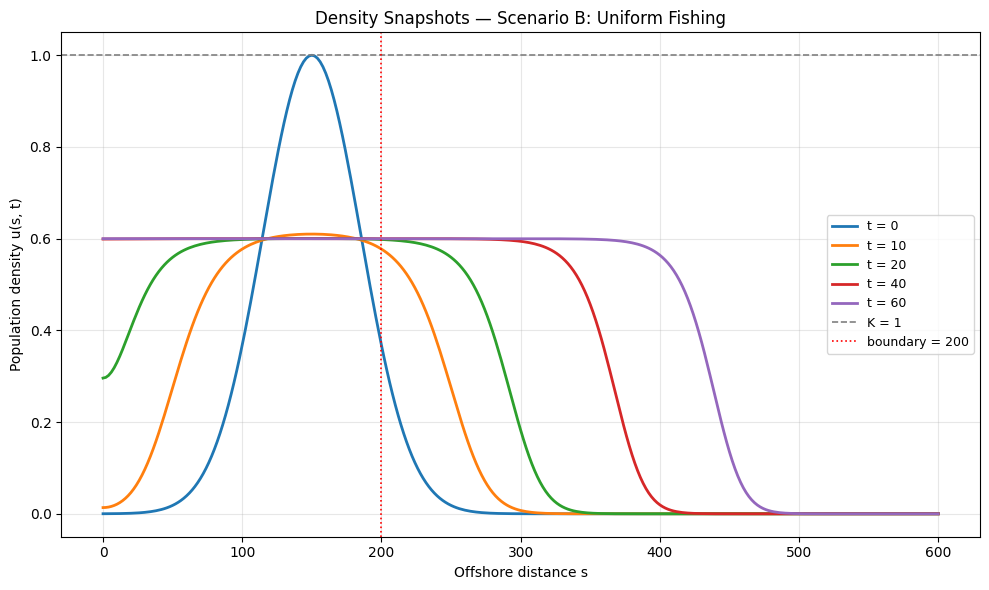

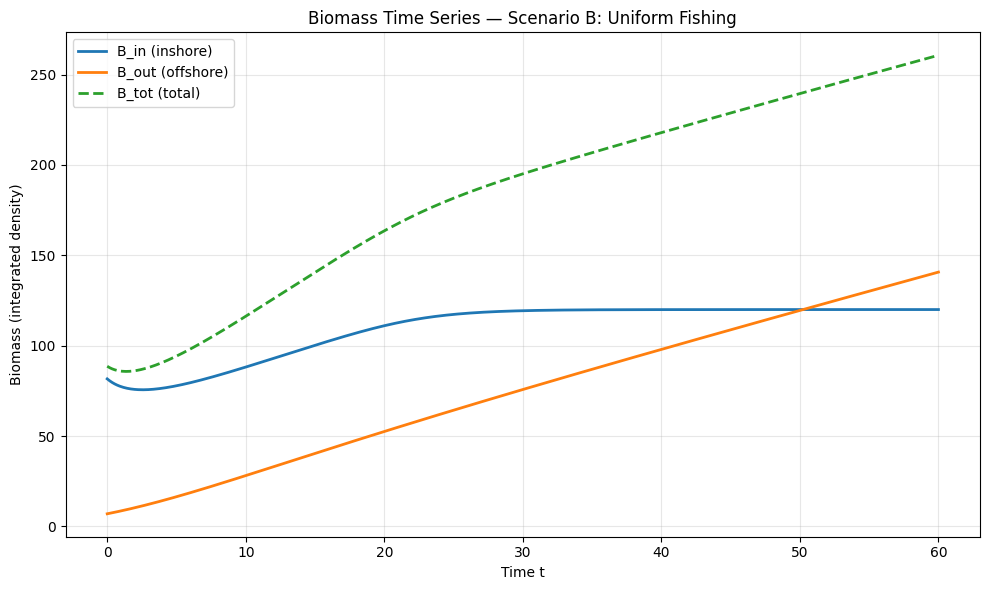

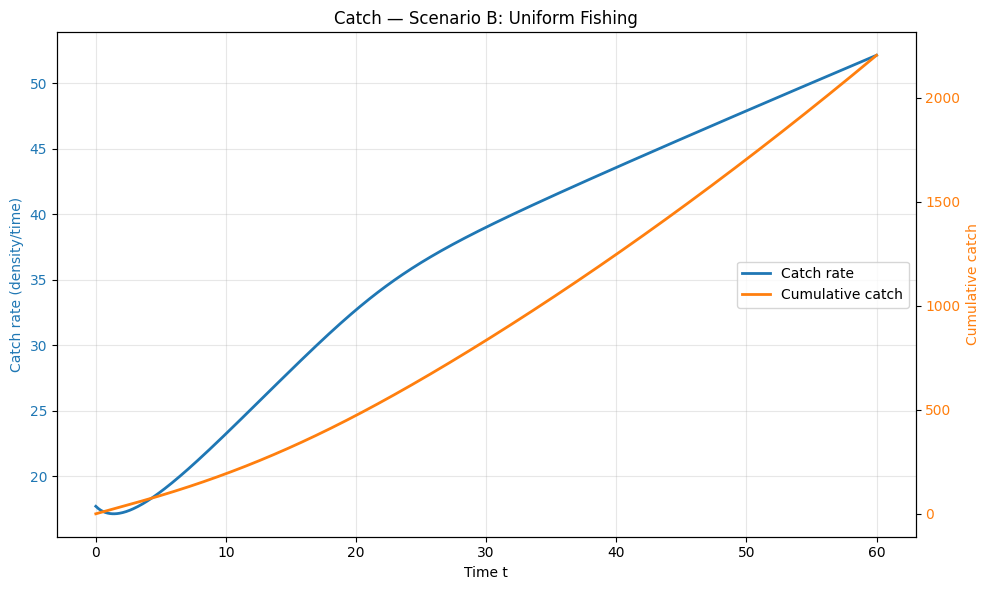

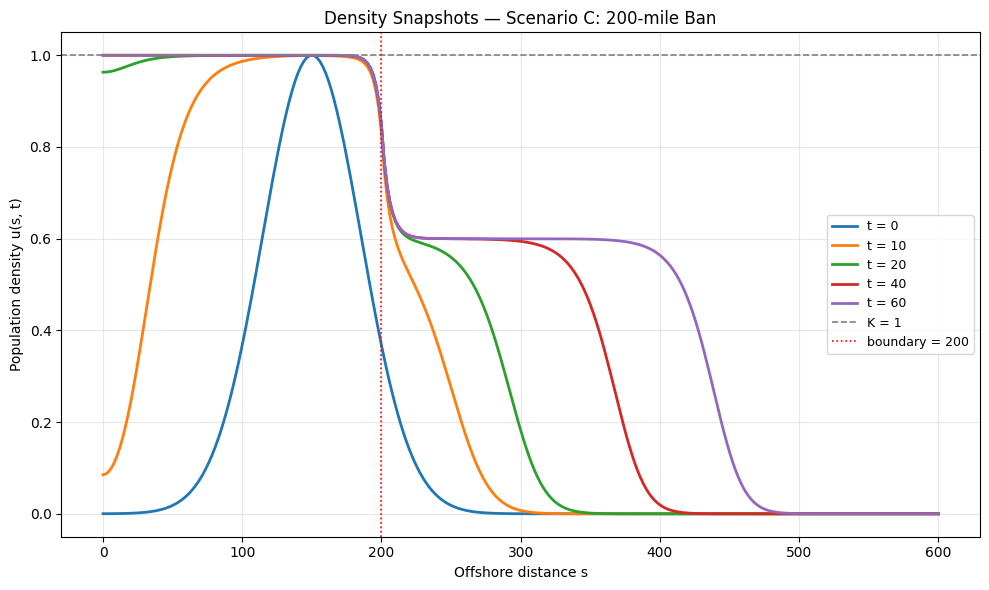

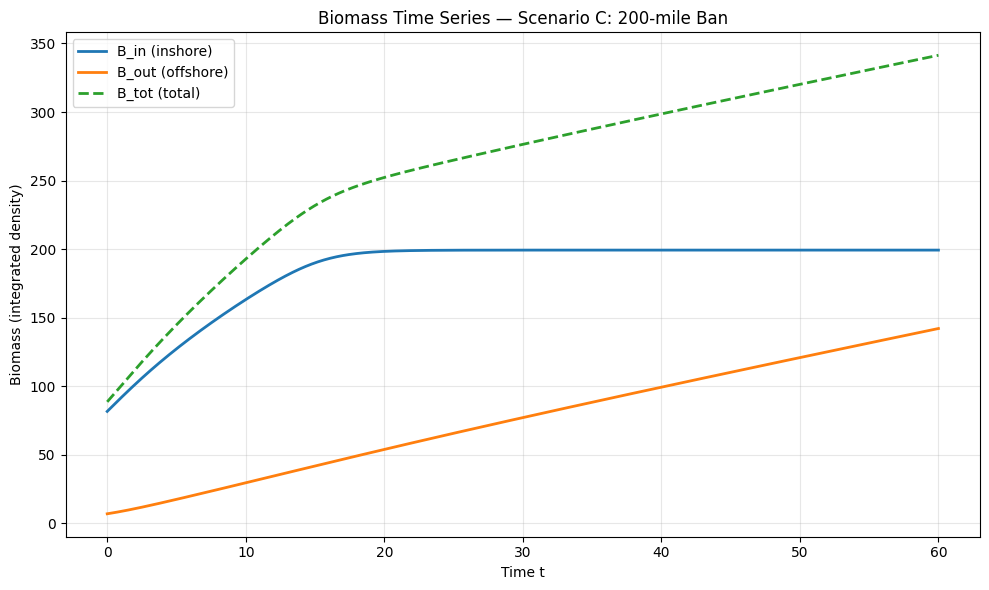

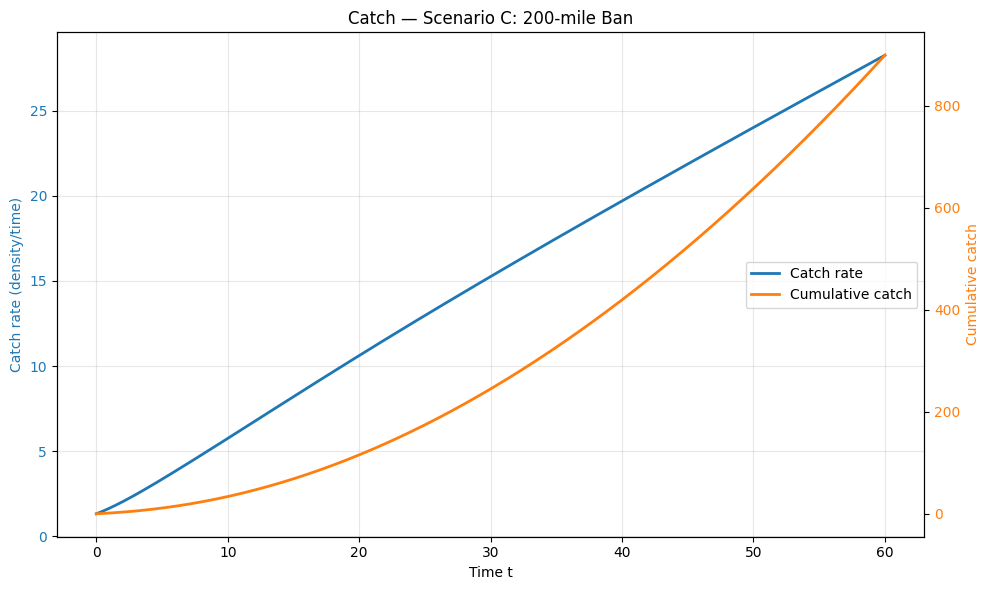

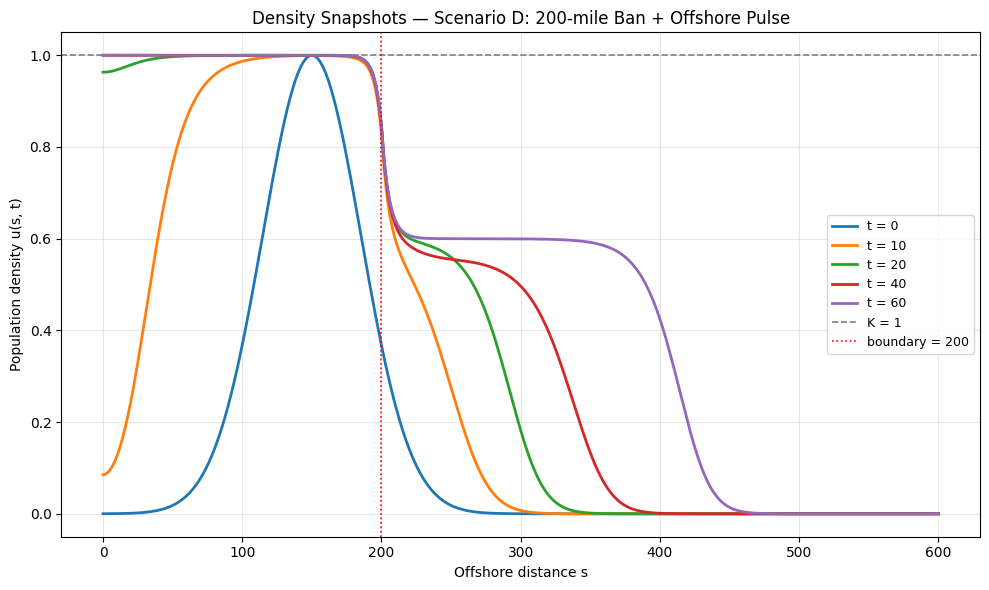

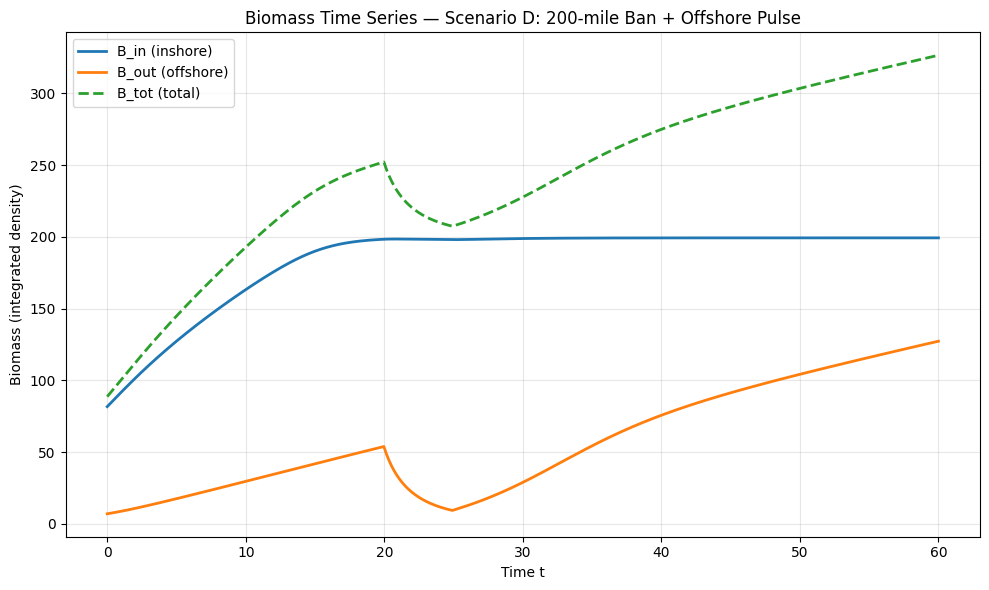

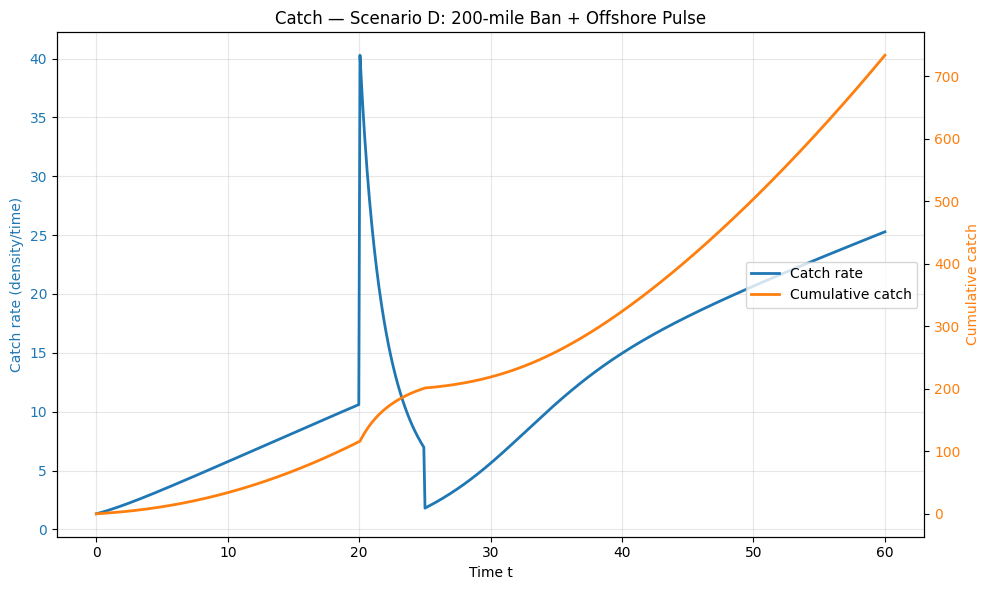

In [7]:
# ── 3C: Run four fishing-policy scenarios ────────────────────────────

# Baseline parameters (same grid as 3A/3B)
L_3c: float = 600.0
N_3c: int = 301
D_3c: float = 10.0
r_3c: float = 0.5
K_3c: float = 1.0
T_end_3c: float = 60.0
S_BND: float = 200.0

SCENARIOS = {
    "A": {"label": "No Fishing (Baseline)",
           "h_in": 0.0, "h_out": 0.0, "pulse": None},
    "B": {"label": "Uniform Fishing",
           "h_in": 0.2, "h_out": 0.2, "pulse": None},
    "C": {"label": "200-mile Ban",
           "h_in": 0.0, "h_out": 0.2, "pulse": None},
    "D": {"label": "200-mile Ban + Offshore Pulse",
           "h_in": 0.0, "h_out": 0.2,
           "pulse": {"t_start": 20.0, "t_end": 25.0, "h_out_pulse": 0.8}},
}

results_3c: dict[str, dict] = {}

for key, scen in SCENARIOS.items():
    res = simulate_rd_fishing(
        L=L_3c, N=N_3c, D=D_3c, r=r_3c, K=K_3c, T_end=T_end_3c,
        s_boundary=S_BND,
        h_in=scen["h_in"], h_out=scen["h_out"], pulse=scen["pulse"],
        store_full=True,
    )
    results_3c[key] = res


# ── Plotting helper functions ────────────────────────────────────────

def plot_snapshots(res: dict, title_suffix: str) -> None:
    """Density snapshot plot for one scenario."""
    fig, ax = plt.subplots(figsize=(10, 6))
    for t_snap in sorted(res["snapshots"]):
        ax.plot(res["s"], res["snapshots"][t_snap],
                linewidth=2.0, label=f"t = {t_snap:g}")
    ax.axhline(K_3c, color="gray", linestyle="--", linewidth=1.2, label=f"K = {K_3c:g}")
    ax.axvline(res["s_boundary"], color="red", linestyle=":", linewidth=1.2,
               label=f"boundary = {res['s_boundary']:g}")
    ax.set_title(f"Density Snapshots — {title_suffix}")
    ax.set_xlabel("Offshore distance s")
    ax.set_ylabel("Population density u(s, t)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    fig.tight_layout()
    plt.show()


def plot_biomass(res: dict, title_suffix: str) -> None:
    """Biomass time-series plot for one scenario."""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(res["time"], res["B_in"], linewidth=2.0, label="B_in (inshore)")
    ax.plot(res["time"], res["B_out"], linewidth=2.0, label="B_out (offshore)")
    ax.plot(res["time"], res["B_tot"], linewidth=2.0, linestyle="--", label="B_tot (total)")
    ax.set_title(f"Biomass Time Series — {title_suffix}")
    ax.set_xlabel("Time t")
    ax.set_ylabel("Biomass (integrated density)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()


def plot_catch(res: dict, title_suffix: str) -> None:
    """Catch rate + cumulative catch (twin axes) for one scenario."""
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color_catch = "tab:blue"
    ax1.plot(res["time"], res["Catch"], linewidth=2.0, color=color_catch, label="Catch rate")
    ax1.set_xlabel("Time t")
    ax1.set_ylabel("Catch rate (density/time)", color=color_catch)
    ax1.tick_params(axis="y", labelcolor=color_catch)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color_cum = "tab:orange"
    ax2.plot(res["time"], res["CumCatch"], linewidth=2.0, color=color_cum, label="Cumulative catch")
    ax2.set_ylabel("Cumulative catch", color=color_cum)
    ax2.tick_params(axis="y", labelcolor=color_cum)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

    ax1.set_title(f"Catch — {title_suffix}")
    fig.tight_layout()
    plt.show()


# ── Generate all plots ───────────────────────────────────────────────

for key, scen in SCENARIOS.items():
    res = results_3c[key]
    tag = f"Scenario {key}: {scen['label']}"

    plot_snapshots(res, tag)
    plot_biomass(res, tag)
    plot_catch(res, tag)

## 3D Surface and Heatmap Visualisations

For each scenario we plot the **full space–time density field** $u(s,t)$:

1. **3D surface plot** — offshore distance $s$ vs time $t$ vs fish density $u$. Multiple viewing angles are shown to give a complete picture.
2. **Heatmap** — the same data as a colour map, with the 200-mile policy boundary marked.

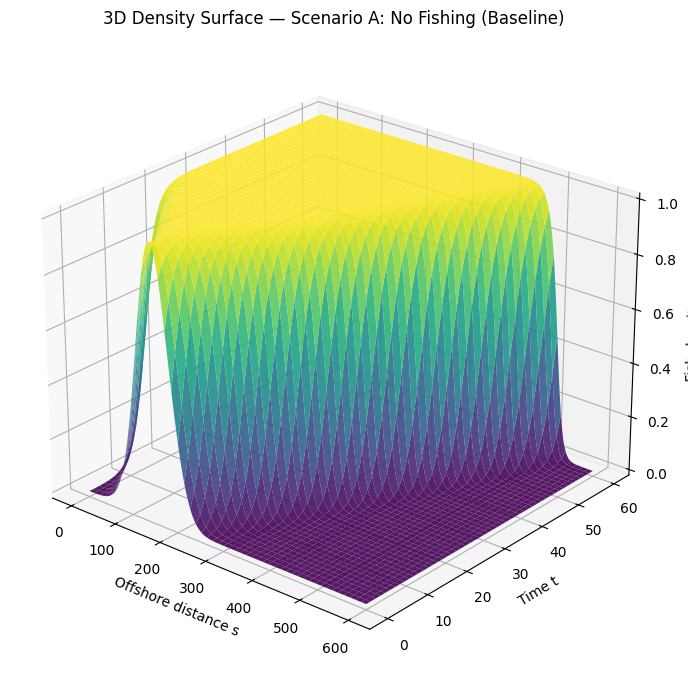

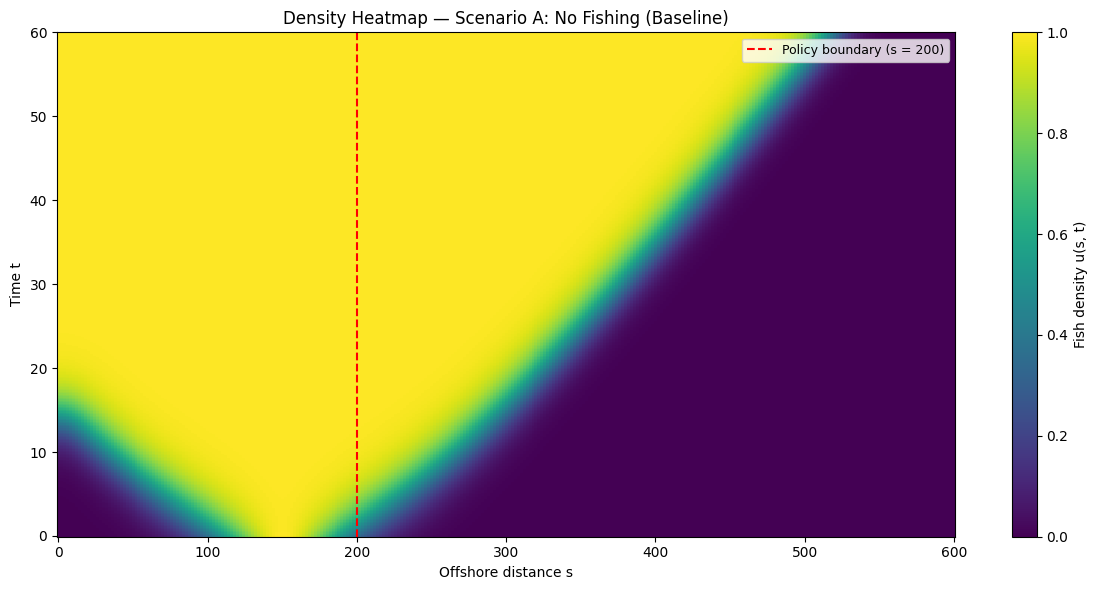

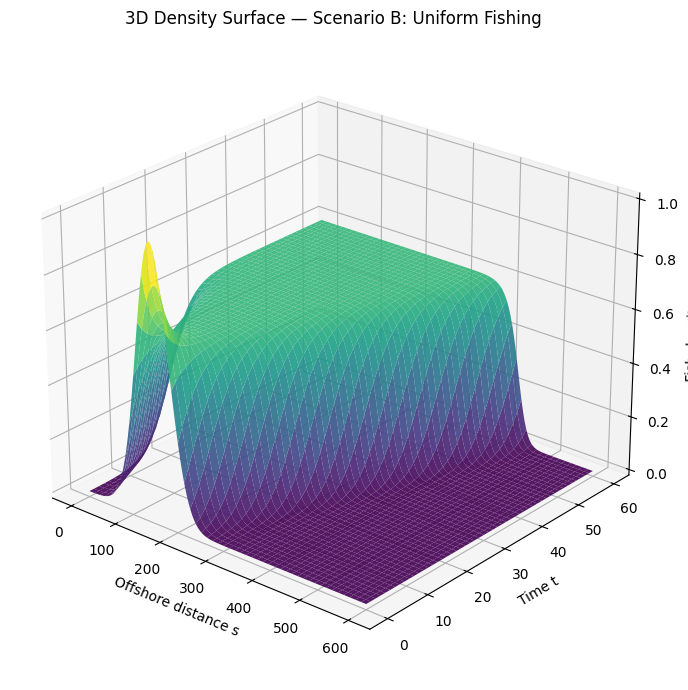

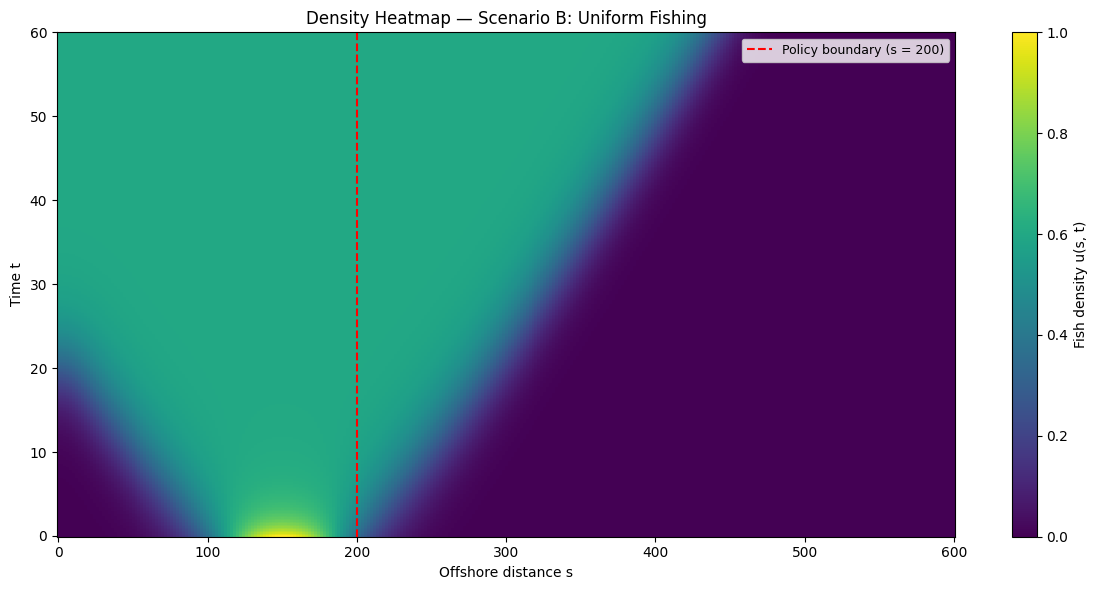

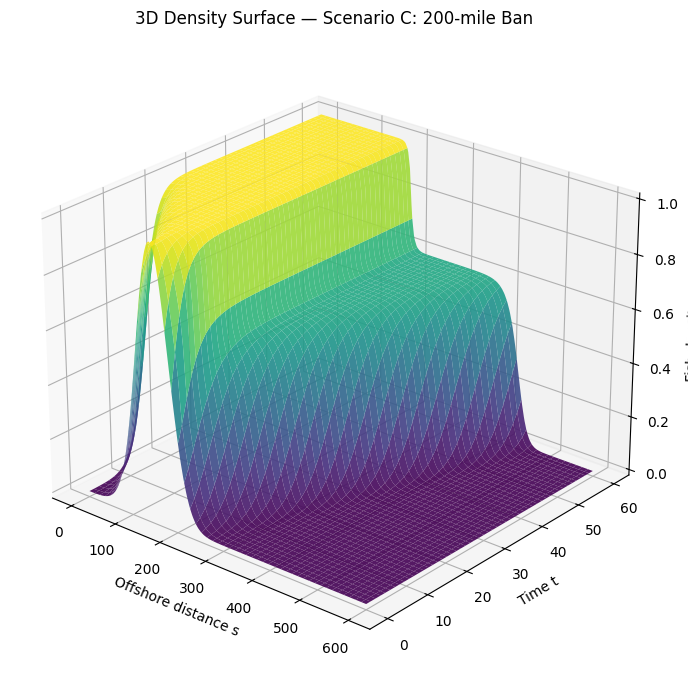

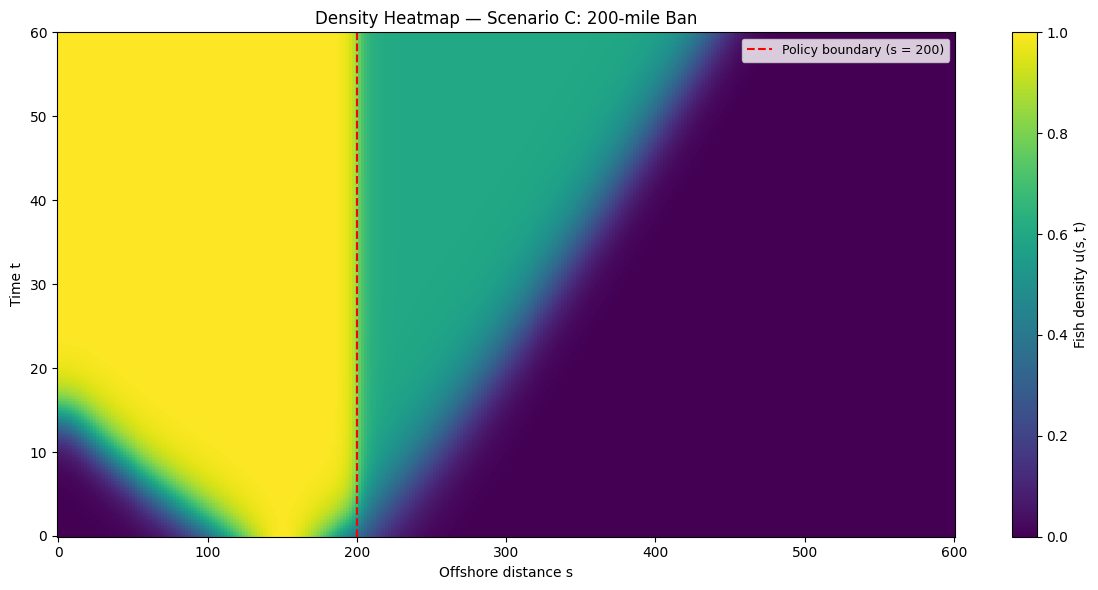

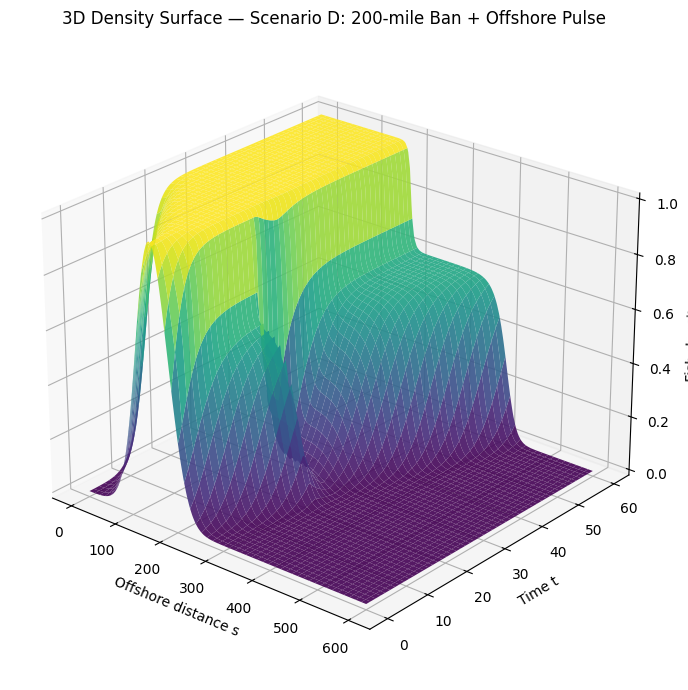

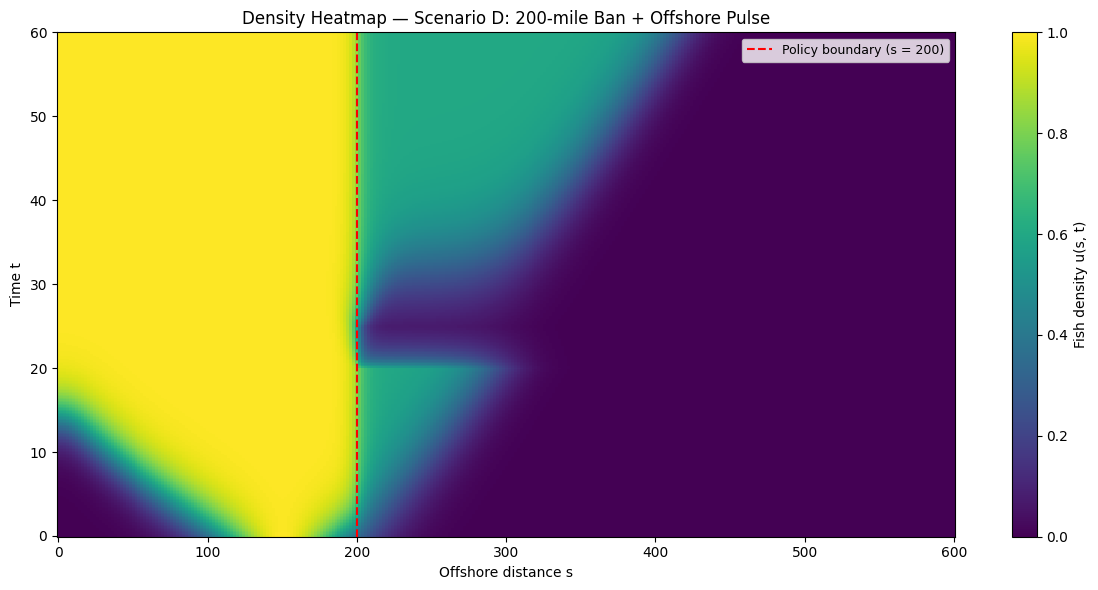

In [8]:
from mpl_toolkits.mplot3d import Axes3D

try:
    import plotly.graph_objects as go
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False
    print("Plotly not available — skipping interactive 3D surfaces (static matplotlib versions will still be shown).")

MAX_PLOT_POINTS = 200

def downsample_surface_data(s_arr, t_arr, u_full, max_points=MAX_PLOT_POINTS):
    if u_full.shape != (len(t_arr), len(s_arr)):
        raise ValueError(
            f"u_full shape {u_full.shape} does not match (len(t_arr), len(s_arr)) "
            f"= ({len(t_arr)}, {len(s_arr)})."
        )

    if len(s_arr) <= max_points and len(t_arr) <= max_points:
        return s_arr, t_arr, u_full

    s_idx = np.linspace(0, len(s_arr) - 1, num=min(len(s_arr), max_points), dtype=int)
    t_idx = np.linspace(0, len(t_arr) - 1, num=min(len(t_arr), max_points), dtype=int)
    return s_arr[s_idx], t_arr[t_idx], u_full[np.ix_(t_idx, s_idx)]

for key, scen in SCENARIOS.items():
    res = results_3c[key]
    tag = f"Scenario {key}: {scen['label']}"

    s_arr = res["s"]
    t_arr = res["t_full"]
    u_full = res["u_full"]

    s_plot, t_plot, u_plot = downsample_surface_data(s_arr, t_arr, u_full)
    S_mesh, T_mesh = np.meshgrid(s_plot, t_plot)

    # — Static matplotlib 3D surface (renders on GitHub) -----------------
    fig_mpl = plt.figure(figsize=(12, 7))
    ax3d = fig_mpl.add_subplot(111, projection="3d")
    ax3d.plot_surface(S_mesh, T_mesh, u_plot, cmap="viridis", edgecolor="none", alpha=0.9)
    ax3d.set_xlabel("Offshore distance s")
    ax3d.set_ylabel("Time t")
    ax3d.set_zlabel("Fish density u")
    ax3d.set_title(f"3D Density Surface — {tag}")
    ax3d.view_init(elev=25, azim=-50)
    fig_mpl.tight_layout()
    plt.show()

    # — Interactive Plotly 3D surface (local use) ------------------------
    if HAS_PLOTLY:
        fig = go.Figure(
            data=[
                go.Surface(
                    x=S_mesh,
                    y=T_mesh,
                    z=u_plot,
                    colorscale="Viridis",
                    colorbar=dict(title="Fish density u(s, t)"),
                )
            ]
        )
        fig.update_layout(
            title=f"3D Density Surface (Interactive) — {tag}",
            scene=dict(
                xaxis_title="Offshore distance s",
                yaxis_title="Time t",
                zaxis_title="Fish density u",
            ),
            margin=dict(l=0, r=0, b=0, t=50),
            width=1000,
            height=700,
        )
        fig.update_scenes(camera=dict(eye=dict(x=1.5, y=-1.5, z=1.0)))
        fig.show()

    # — Heatmap ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 6))
    pcm = ax.pcolormesh(
        s_arr, t_arr, u_full,
        cmap="viridis", shading="auto",
    )
    ax.axvline(
        res["s_boundary"], color="red", linestyle="--", linewidth=1.5,
        label=f"Policy boundary (s = {res['s_boundary']:g})",
    )
    ax.set_xlabel("Offshore distance s")
    ax.set_ylabel("Time t")
    ax.set_title(f"Density Heatmap — {tag}")
    cb = fig.colorbar(pcm, ax=ax)
    cb.set_label("Fish density u(s, t)")
    ax.legend(loc="upper right", fontsize=9)
    fig.tight_layout()
    plt.show()